# import and process dataset

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# read data
df = pd.read_csv('train.csv', index_col=0)  # first column as index

# process
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.T)  # transform date to row, company to column

# create time series data
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 60  # use 60 days for prediction
X, y = create_dataset(scaled_data, look_back)

# split train data and vaild data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# transform to torch
import torch
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# device
device_use_cuda = False
device = torch.device("cuda" if (device_use_cuda and torch.cuda.is_available()) else "cpu")

# define model

In [20]:
import torch.nn as nn

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm  = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# optuna

In [21]:
import optuna

def objective(trial):
    params = {
        'hidden_size': trial.suggest_int('hidden_size', 32, 256),
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    
    # data loader
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=params['batch_size'],
        shuffle=True
    )
    
    # init model
    model = StockRNN(
        input_size=X_train.shape[2],
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        output_size=y_train.shape[1],
        dropout=params['dropout']
    )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # train loop
    for epoch in range(10):  # fast evaluate for permeters
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'\rEpoch {epoch+1}/10, train loss: {loss.item():.4f}', end='', flush=True)
    
    # vaild loss
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
    
    return val_loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"best: {best_params}")

[I 2025-03-27 15:37:53,663] A new study created in memory with name: no-name-84ea4ef4-7265-4243-a3ec-8f877c5ba48e


Epoch 10/10, train loss: 0.0030

[I 2025-03-27 15:38:33,387] Trial 0 finished with value: 0.006097008939832449 and parameters: {'hidden_size': 175, 'num_layers': 2, 'dropout': 0.24218865672116247, 'learning_rate': 0.00014160787686939798, 'batch_size': 128}. Best is trial 0 with value: 0.006097008939832449.


Epoch 10/10, train loss: 0.0025

[I 2025-03-27 15:40:00,364] Trial 1 finished with value: 0.0056054480373859406 and parameters: {'hidden_size': 50, 'num_layers': 1, 'dropout': 0.15374311301537558, 'learning_rate': 0.003345368954444365, 'batch_size': 64}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0021

[I 2025-03-27 15:40:13,578] Trial 2 finished with value: 0.00582735612988472 and parameters: {'hidden_size': 68, 'num_layers': 1, 'dropout': 0.23396756395942142, 'learning_rate': 0.00048627648175167767, 'batch_size': 64}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0023

[I 2025-03-27 15:41:20,812] Trial 3 finished with value: 0.005646493285894394 and parameters: {'hidden_size': 240, 'num_layers': 2, 'dropout': 0.3564910444734023, 'learning_rate': 0.0009310915015315832, 'batch_size': 32}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0033

[I 2025-03-27 15:51:50,561] Trial 4 finished with value: 0.005752793047577143 and parameters: {'hidden_size': 228, 'num_layers': 1, 'dropout': 0.40889392651798007, 'learning_rate': 0.007304939854928219, 'batch_size': 32}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0021

[I 2025-03-27 15:55:14,557] Trial 5 finished with value: 0.005617919843643904 and parameters: {'hidden_size': 182, 'num_layers': 4, 'dropout': 0.1436212216285333, 'learning_rate': 0.006126151429083349, 'batch_size': 128}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0027

[I 2025-03-27 15:55:44,291] Trial 6 finished with value: 0.00613031443208456 and parameters: {'hidden_size': 126, 'num_layers': 2, 'dropout': 0.29692117681251223, 'learning_rate': 0.00012061469703580739, 'batch_size': 64}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0029

[I 2025-03-27 15:57:38,798] Trial 7 finished with value: 0.0056635248474776745 and parameters: {'hidden_size': 209, 'num_layers': 4, 'dropout': 0.444495167050463, 'learning_rate': 0.0021463156837774324, 'batch_size': 32}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0021

[I 2025-03-27 15:58:11,457] Trial 8 finished with value: 0.005704911891371012 and parameters: {'hidden_size': 187, 'num_layers': 1, 'dropout': 0.3865008463758348, 'learning_rate': 0.0019423435361576224, 'batch_size': 32}. Best is trial 1 with value: 0.0056054480373859406.


Epoch 10/10, train loss: 0.0022

[I 2025-03-27 15:58:29,559] Trial 9 finished with value: 0.0056884014047682285 and parameters: {'hidden_size': 36, 'num_layers': 1, 'dropout': 0.2159514105155901, 'learning_rate': 0.0016658025706583165, 'batch_size': 32}. Best is trial 1 with value: 0.0056054480373859406.


best: {'hidden_size': 50, 'num_layers': 1, 'dropout': 0.15374311301537558, 'learning_rate': 0.003345368954444365, 'batch_size': 64}


# train the best model

In [22]:
# use the best model
model = StockRNN(
    input_size=X_train.shape[2],
    output_size=y_train.shape[1],
    **{k: v for k, v in best_params.items() if k in ['hidden_size', 'num_layers', 'dropout']}
)

# parmeters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True
)

# train
num_epochs = 100
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {loss.item()}, vaild MSE: {test_loss.item()}')

Epoch [1/100], train loss: 0.00444765156134963, vaild MSE: 0.007804252672940493
Epoch [10/100], train loss: 0.0020649826619774103, vaild MSE: 0.005596451461315155
Epoch [20/100], train loss: 0.0024123177863657475, vaild MSE: 0.0056297555565834045
Epoch [30/100], train loss: 0.002468589460477233, vaild MSE: 0.005602622404694557
Epoch [40/100], train loss: 0.0028003226034343243, vaild MSE: 0.005604188423603773
Epoch [50/100], train loss: 0.0020961081609129906, vaild MSE: 0.005601333919912577
Epoch [60/100], train loss: 0.002117062220349908, vaild MSE: 0.005589755717664957
Epoch [70/100], train loss: 0.002504671923816204, vaild MSE: 0.0055923606269061565
Epoch [80/100], train loss: 0.0027880726847797632, vaild MSE: 0.005742618348449469
Epoch [90/100], train loss: 0.00227043847553432, vaild MSE: 0.005659728776663542
Epoch [100/100], train loss: 0.0022573904134333134, vaild MSE: 0.005494097713381052


# write prediction

In [ ]:
# use last look_back days to predict next day
last_window = scaled_data[-look_back:]
last_window_tensor = torch.FloatTensor(last_window[np.newaxis, ...])

with torch.no_grad():
    next_day_pred = model(last_window_tensor)

# transfomr
next_day_pred = scaler.inverse_transform(next_day_pred.numpy())

# submission
submission = pd.DataFrame({
    'ID': df.index,
    'value': next_day_pred[0]
})
submission.to_csv('submission_lstm11.csv', index=False)

# captum

In [31]:
input_sample = X_test[-1].unsqueeze(0)
input_sample.requires_grad_()

tensor([[[0.5744, 0.7388, 0.4595,  ..., 0.7284, 0.5552, 0.5696],
         [0.5086, 0.7056, 0.5036,  ..., 0.7673, 0.5920, 0.5425],
         [0.5358, 0.6638, 0.3602,  ..., 0.7207, 0.4675, 0.5671],
         ...,
         [0.6104, 0.6945, 0.4977,  ..., 0.7421, 0.5837, 0.5932],
         [0.5938, 0.7042, 0.5240,  ..., 0.6953, 0.6129, 0.5830],
         [0.6131, 0.7419, 0.5947,  ..., 0.7563, 0.6793, 0.6433]]],
       requires_grad=True)

## feature

Company: 442/442 | Mean Attribution: 0.0088564455509185795

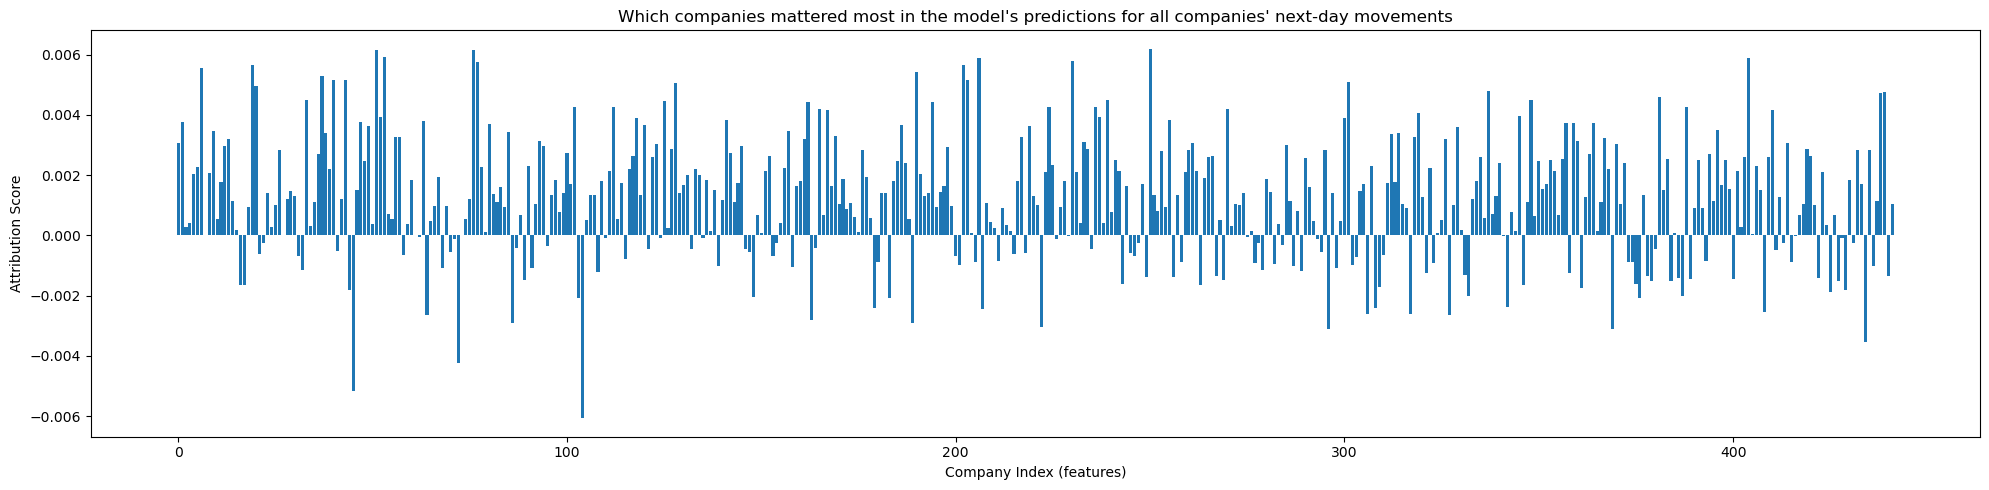

In [32]:
from captum.attr import IntegratedGradients

# init Integrated Gradients
ig = IntegratedGradients(model)

# Use the most recent input sample (last 60-day window)
baseline = torch.zeros_like(input_sample)

# each companys as feature
total_attributions = torch.zeros_like(input_sample[0])

# Loop through each company to get attribution for its prediction
for target_company in range(y_test.shape[1]):
    attributions, _ = ig.attribute(
        input_sample,
        baselines=baseline,
        target=target_company,
        return_convergence_delta=True
    )
    total_attributions += attributions.squeeze(0)
    print(f"\rCompany: {target_company+1}/{y_test.shape[1]} | "f"Mean Attribution: {total_attributions.mean()}",end='', flush=True)

# Average attribution over all companies
avg_attributions = total_attributions / y_test.shape[1]

# Sum across time dimension to get final attribution per company
company_importance = avg_attributions.sum(dim=0).detach().numpy()  # shape: [442]

# Plot bar chart
plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(company_importance)), company_importance)
plt.xlabel("Company Index (features)")
plt.ylabel("Attribution Score")
plt.title("Which companies mattered most in the model's predictions for all companies' next-day movements")
plt.tight_layout()
plt.show()

## layer

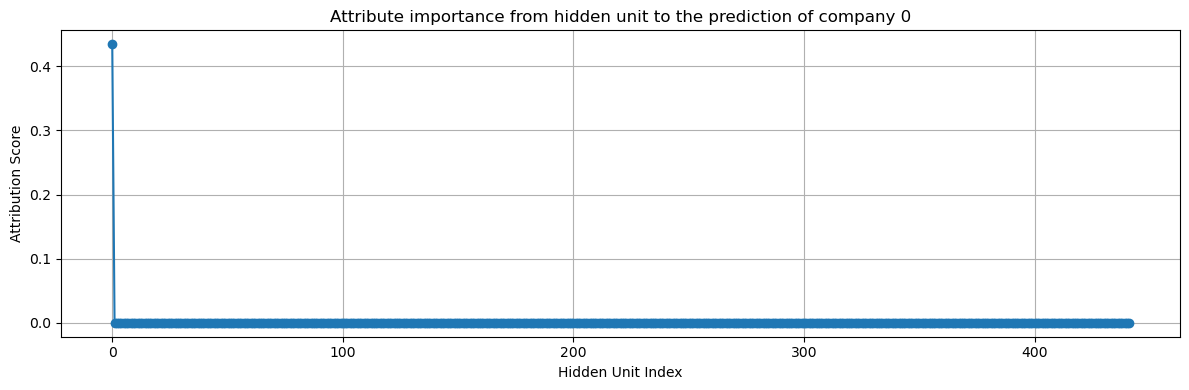

In [33]:
from captum.attr import LayerConductance

# init
cond = LayerConductance(model, model.fc)

# contribute to company 0
attributions = cond.attribute(input_sample, target=0)

attr_np = attributions.squeeze().detach().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.plot(attr_np, marker='o')
plt.title("Attribute importance from hidden unit to the prediction of company 0")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Attribution Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# neuron

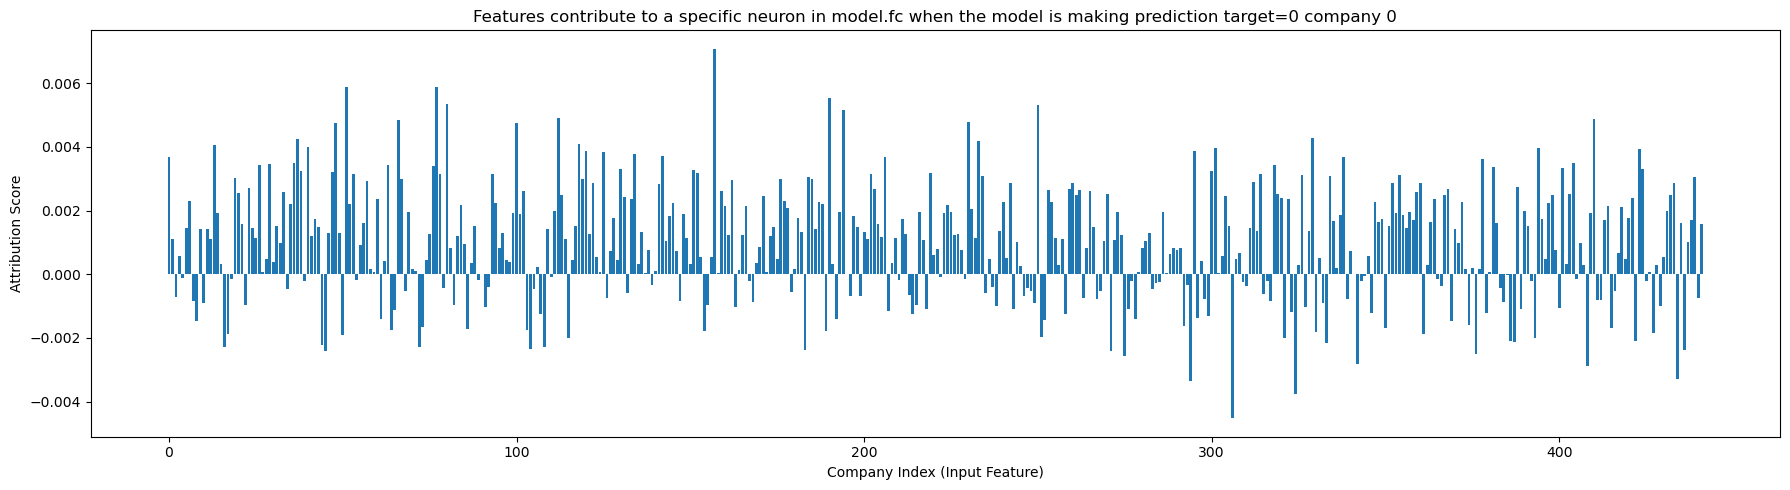

In [34]:
from captum.attr import NeuronConductance

# init
neuron_cond = NeuronConductance(model, model.fc)

neuron_index = 0  # for example: company 0
attributions = neuron_cond.attribute(input_sample, neuron_selector=neuron_index, target=0)

company_attr = attributions.sum(dim=1).squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(18, 5))
plt.bar(np.arange(len(company_attr)), company_attr)
plt.title("Features contribute to a specific neuron in model.fc when the model is making prediction target=0 company 0")
plt.xlabel("Company Index (Input Feature)")
plt.ylabel("Attribution Score")
plt.tight_layout()
plt.show()